In [60]:
import pandas as pd
from matplotlib import pyplot as plt
import tbparse
from typing import List, Dict
import numpy as np
import glob
plt.rcParams["font.family"] = "arial"
plt.rc('font', size=12)
cm = 1/2.54

### Tools

In [17]:
def find_tag(df:pd.DataFrame, search:str):
    return [tag for tag in df["tag"].unique() if search in tag]

def filter_tag(df, tags: List[str] or str):
    if isinstance(tags, str):
        filtered = df[df["tag"] == tags][["step", "value"]].set_index("step")
    else:
        filtered = {tag: filter_tag(df, tag) for tag in tags}
    return filtered

def mean(dfs: List[pd.DataFrame] or Dict[List[pd.DataFrame]]):
    if isinstance(dfs, dict):
        return {tag: mean(df) for tag, df in dfs.items()}
    else:
        full_data:pd.DataFrame = dfs[0]
        for i, df in enumerate(dfs[1:]):
            full_data = full_data.join(df, rsuffix=str(i), how="outer")
        full_data.interpolate(inplace = True)
        mean_data = pd.DataFrame(full_data.mean(axis=1), columns=["value"])
        return mean_data

def import_data(path, run_name, tags: List[str] or str = None, exclude = []) -> List[pd.DataFrame] or Dict[List[pd.DataFrame]]:
    assert isinstance(exclude, list), "Exclude has to be a List"
    experiments = glob.glob(path + "/" + run_name + "*")
    experiments = [exp for exp in experiments if not any([exc in exp for exc in exclude])]
    dfs = {tag:[] for tag in tags} if isinstance(tags, list) else []
    for experiment in experiments:
        data = tbparse.SummaryReader(experiment).scalars
        if tags is not None:
            data = filter_tag(data, tags)
        if isinstance(data, dict):
            for tag in data.keys():
                dfs[tag].append(data[tag])
        else:
            dfs.append(data)
    return dfs

def plot(dfs, labels, x_label, y_label, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    for df, label in zip(dfs, labels):
        ax.plot(df.index, df["value"], label=label)
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if ax is None:
        return fig

# Routing Experimente in Minimatrix

In [3]:
path = "../../logs/minimatrix_routing/"

## Single Agent vs Multi Agent

In [4]:
results_sa = mean(import_data(path, "01_konzept_sa", 'ray/tune/episode_reward_mean'))
results_ma = mean(import_data(path, "01_konzept_ma", 'ray/tune/episode_reward_mean'))

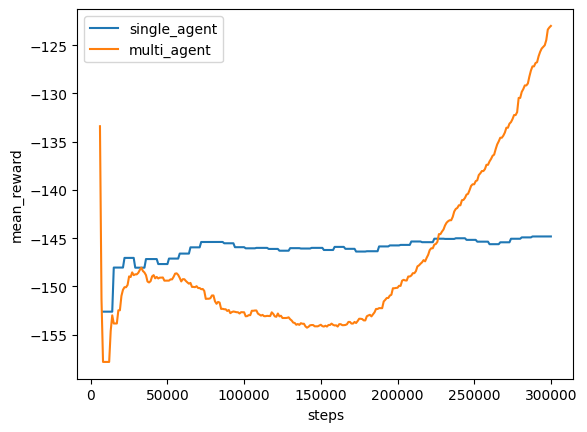

In [5]:
fig = plot([results_sa, results_ma], ["single_agent", "multi_agent"], "steps", "mean_reward")

In [7]:
fig.savefig("test.jpg", dpi=600)

## Algorithmus Auswahl

In [21]:
results_ppo = mean(import_data(path, "01_konzept_ma", 'ray/tune/episode_reward_mean'))
results_a2c = mean(import_data(path, "02_algorithmus_a2c", 'ray/tune/episode_reward_mean'))
results_apex = mean(import_data(path, "02_algorithmus_apex", 'ray/tune/episode_reward_mean'))
results_dqn = mean(import_data(path, "02_algorithmus_dqn", 'ray/tune/episode_reward_mean'))
results_rainbow = mean(import_data(path, "02_algorithmus_rainbow", 'ray/tune/episode_reward_mean'))

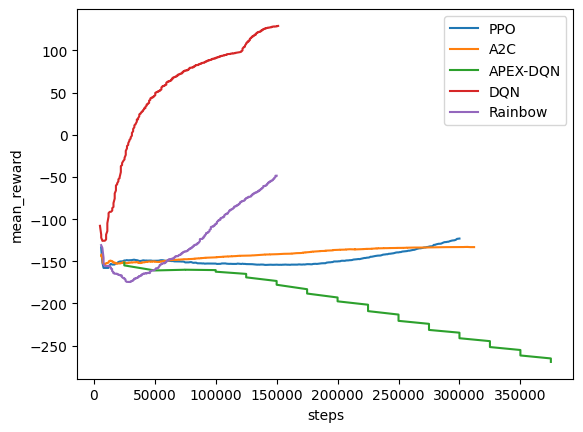

In [22]:
plot([results_ppo, results_a2c, results_apex, results_dqn, results_rainbow], ["PPO", "A2C", "APEX-DQN", "DQN", "Rainbow"], "steps", "mean_reward")

## Auswahl Gammawert

In [25]:
results_098 = mean(import_data(path, "02_algorithmus_dqn", 'ray/tune/episode_reward_mean'))
results_0999 = mean(import_data(path, "03_gamma_0_999", 'ray/tune/episode_reward_mean'))
results_09 = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))

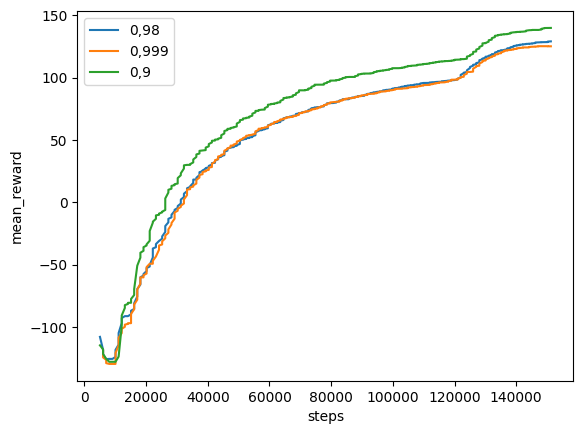

In [26]:
plot([results_098, results_0999, results_09], ["0,98", "0,999", "0,9"], "steps", "mean_reward")

## Learning Rate

In [27]:
results_3 = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))
results_4 = mean(import_data(path, "04_lr_e4", 'ray/tune/episode_reward_mean'))
results_5 = mean(import_data(path, "04_lr_e5", 'ray/tune/episode_reward_mean'))

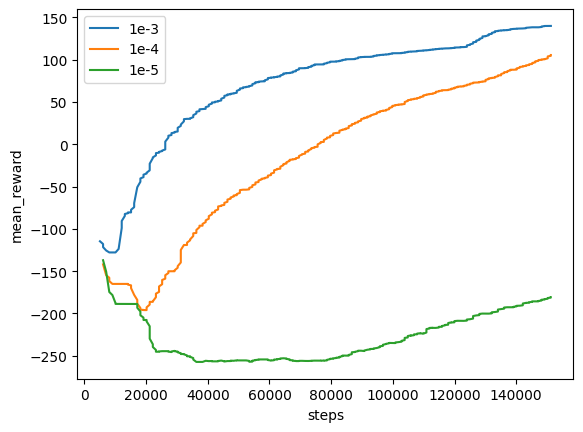

In [28]:
plot([results_3, results_4, results_5], ["1e-3", "1e-4", "1e-5"], "steps", "mean_reward")

## Model

In [29]:
results_lin = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))
results_attn = mean(import_data(path, "05_model_attn", 'ray/tune/episode_reward_mean'))
results_gnn = mean(import_data(path, "05_model_gnn", 'ray/tune/episode_reward_mean', exclude = ["09-34"]))

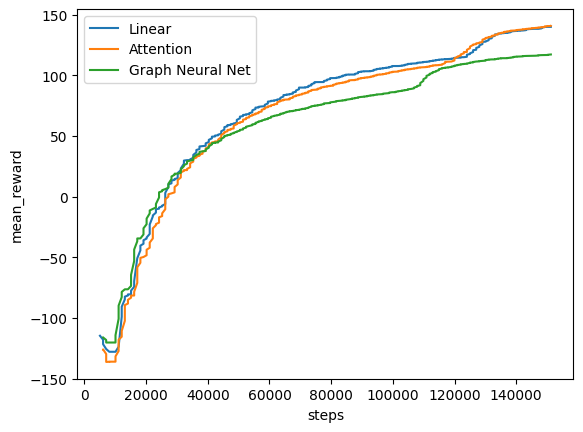

In [30]:
plot([results_lin, results_attn, results_gnn], ["Linear", "Attention", "Graph Neural Net"], "steps", "mean_reward")

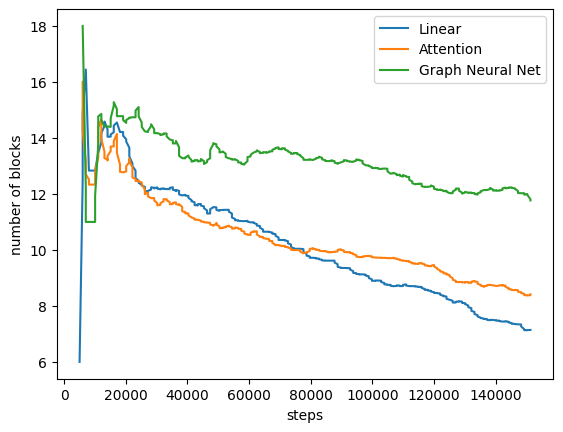

In [51]:
results_lin = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/custom_metrics/block_mean'))
results_attn = mean(import_data(path, "05_model_attn", 'ray/tune/custom_metrics/block_mean'))
results_gnn = mean(import_data(path, "05_model_gnn", 'ray/tune/custom_metrics/block_mean', exclude = ["09-34"]))
plot([results_lin, results_attn, results_gnn], ["Linear", "Attention", "Graph Neural Net"], "steps", "number of blocks")

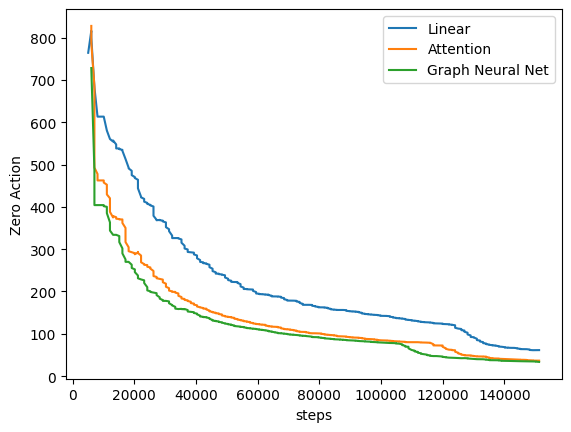

In [52]:
results_lin = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/custom_metrics/taken_invalid_mean'))
results_attn = mean(import_data(path, "05_model_attn", 'ray/tune/custom_metrics/taken_invalid_mean'))
results_gnn = mean(import_data(path, "05_model_gnn", 'ray/tune/custom_metrics/taken_invalid_mean', exclude = ["09-34"]))
plot([results_lin, results_attn, results_gnn], ["Linear", "Attention", "Graph Neural Net"], "steps", "Zero Action")

## Modellbreite

In [26]:
results_16 = mean(import_data(path, "06_embed_16", 'ray/tune/episode_reward_mean'))
results_32 = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))
results_64 = mean(import_data(path, "06_embed_64", 'ray/tune/episode_reward_mean'))

IndexError: list index out of range

In [25]:
plot([results_16, results_32, results_64], ["16", "32", "64"], "steps", "mean_reward")

NameError: name 'results_16' is not defined

## Action Masking

In [33]:
results_with = mean(import_data(path, "07_action_masking_on__2_10_2023-01-01_19-01-24262oqu3p", 'ray/tune/episode_reward_mean'))
results_without = mean(import_data(path, "06_embed_64", 'ray/tune/episode_reward_mean'))

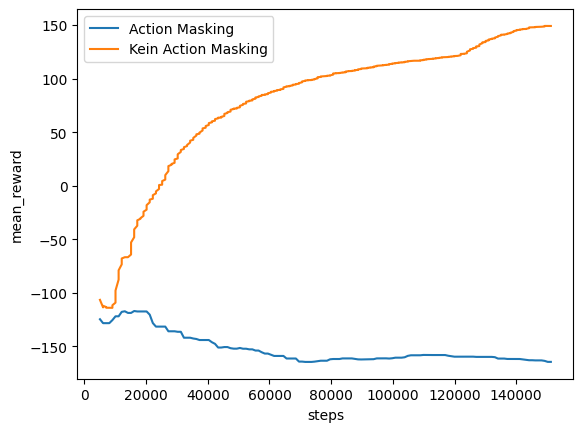

In [34]:
plot([results_with, results_without], ["Action Masking", "Kein Action Masking"], "steps", "mean_reward")

## Coordinate Embedding

In [42]:
results_without = mean(import_data(path, "06_embed_64", 'ray/tune/episode_reward_mean'))
results_embedding = mean(import_data(path, "08_position_embedding", 'ray/tune/episode_reward_mean'))
results_fourier = mean(import_data(path, "08_position_fourier", 'ray/tune/episode_reward_mean', exclude=["17-28-58"]))

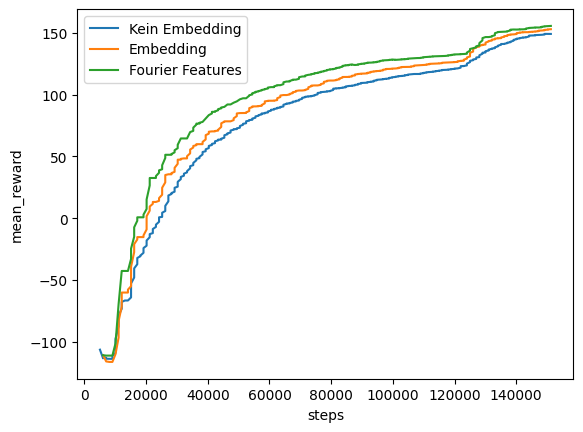

In [43]:
plot([results_without, results_embedding, results_fourier], ["Kein Embedding", "Embedding", "Fourier Features"], "steps", "mean_reward")

In [49]:
results_without = mean(import_data(path, "06_embed_64", 'ray/tune/custom_metrics/block_mean'))
results_embedding = mean(import_data(path, "08_position_embedding", 'ray/tune/custom_metrics/block_mean'))
results_fourier = mean(import_data(path, "08_position_fourier", 'ray/tune/custom_metrics/block_mean', exclude=["17-28-58"]))

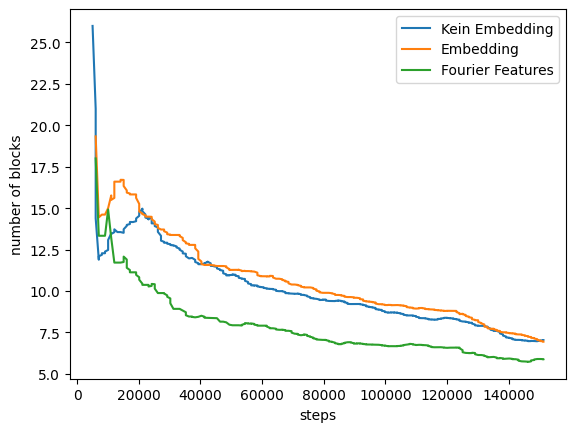

In [50]:
plot([results_without, results_embedding, results_fourier], ["Kein Embedding", "Embedding", "Fourier Features"], "steps", "number of blocks")

## Episodenlänge

In [44]:
results_never = mean(import_data(path, "08_position_fourier", 'ray/tune/episode_reward_mean', exclude=["17-28-58"]))
results_block = mean(import_data(path, "09_episode_block", 'ray/tune/episode_reward_mean'))
results_fourier = mean(import_data(path, "09_episode_target", 'ray/tune/episode_reward_mean', exclude=["18-27-32", "04-52-24"]))

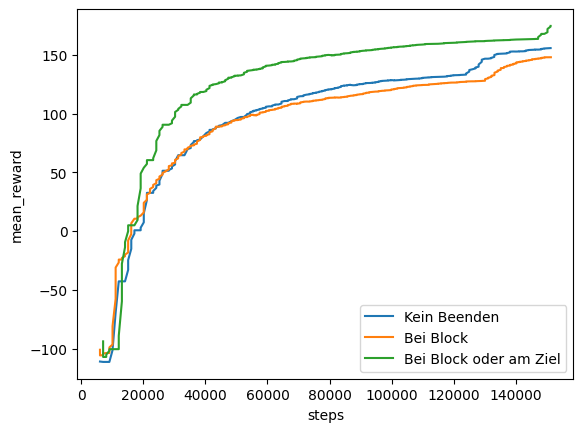

In [46]:
plot([results_never, results_block, results_fourier], ["Kein Beenden", "Bei Block", "Bei Block oder am Ziel"], "steps", "mean_reward")

In [47]:
blocks_never = mean(import_data(path, "08_position_fourier", 'ray/tune/custom_metrics/block_mean', exclude=["17-28-58"]))
blocks_block = mean(import_data(path, "09_episode_block", 'ray/tune/custom_metrics/block_mean'))
blocks_fourier = mean(import_data(path, "09_episode_target", 'ray/tune/custom_metrics/block_mean', exclude=["18-27-32", "04-52-24"]))

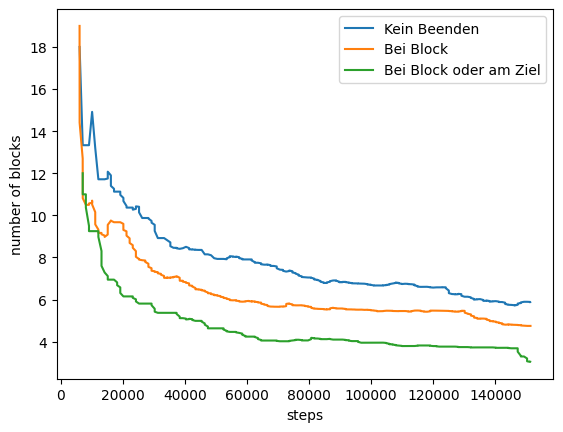

In [48]:
plot([blocks_never, blocks_block, blocks_fourier], ["Kein Beenden", "Bei Block", "Bei Block oder am Ziel"], "steps", "number of blocks")

# Routing-Experimente in Matrix

In [19]:
path = "../../logs/matrix_routing/"

## Model

C:\Users\Wegma\AppData\Local\Temp\ipykernel_20072\3139792552.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


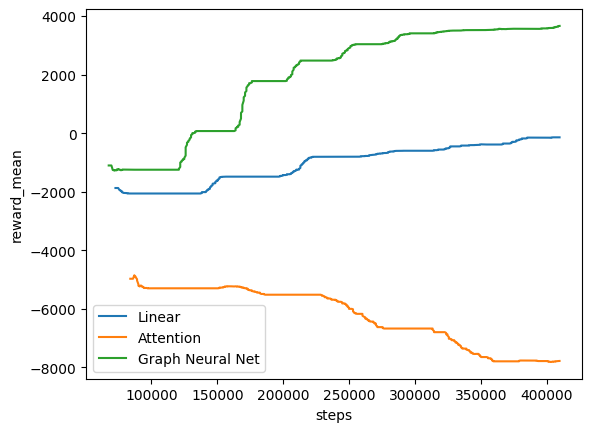

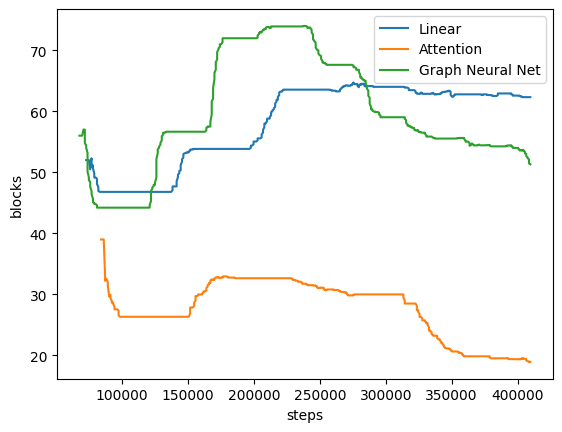

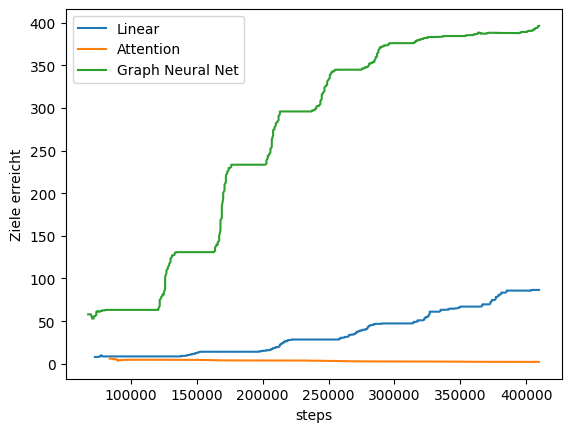

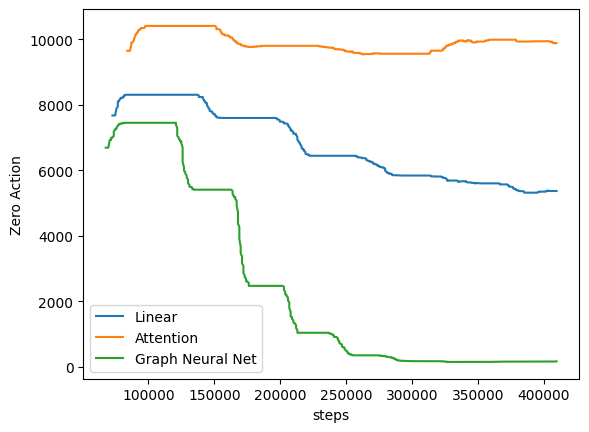

In [6]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_lin = mean(import_data(path, "01_model_lin", tags))
results_attn = mean(import_data(path, "01_model_attn", tags))
results_gnn = mean(import_data(path, "01_model_gnn", tags))
for tag, label in zip(tags, ["reward_mean", "blocks", "Ziele erreicht", "Zero Action"]):
    plot([results_lin[tag], results_attn[tag], results_gnn[tag]], ["Linear", "Attention", "Graph Neural Net"], "steps", label)

## Gamma

C:\Users\Wegma\AppData\Local\Temp\ipykernel_20072\3139792552.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


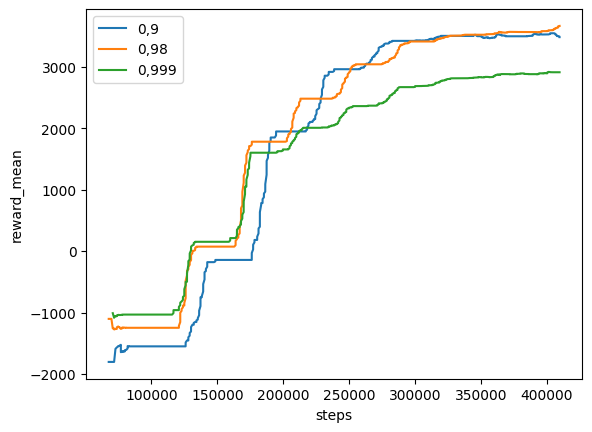

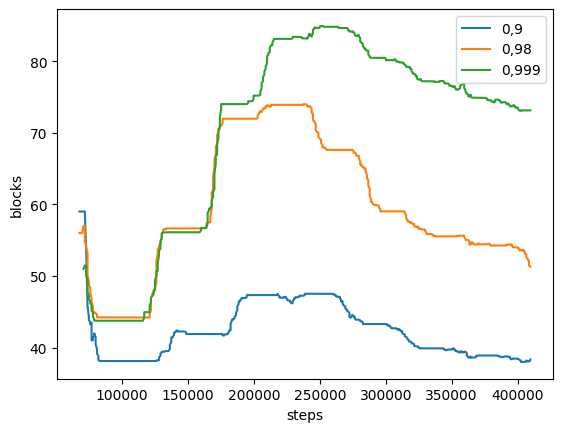

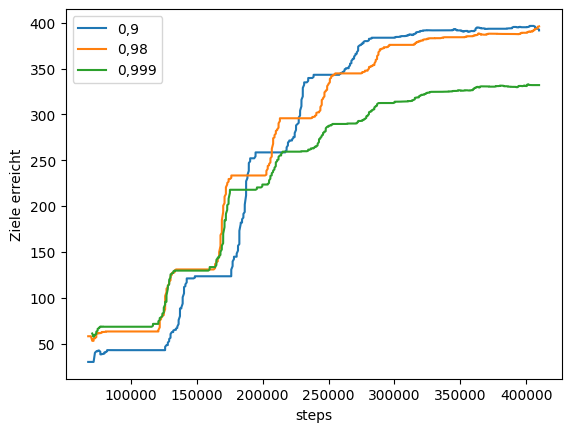

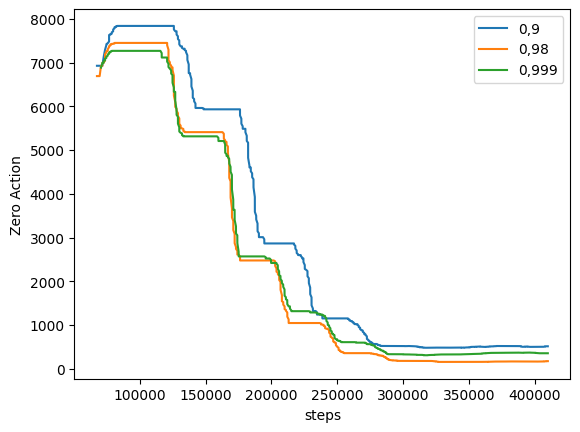

In [8]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_9 = mean(import_data(path, "02_gamma_0_9_", tags))
results_98 = mean(import_data(path, "01_model_gnn", tags))
results_999 = mean(import_data(path, "02_gamma_0_999_", tags))
for tag, label in zip(tags, ["reward_mean", "blocks", "Ziele erreicht", "Zero Action"]):
    plot([results_9[tag], results_98[tag], results_999[tag]], ["0,9", "0,98", "0,999"], "steps", label)

## Learning Rate

C:\Users\Wegma\AppData\Local\Temp\ipykernel_20072\3139792552.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


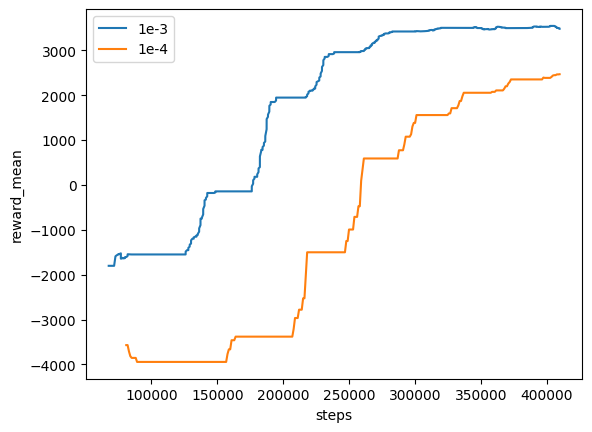

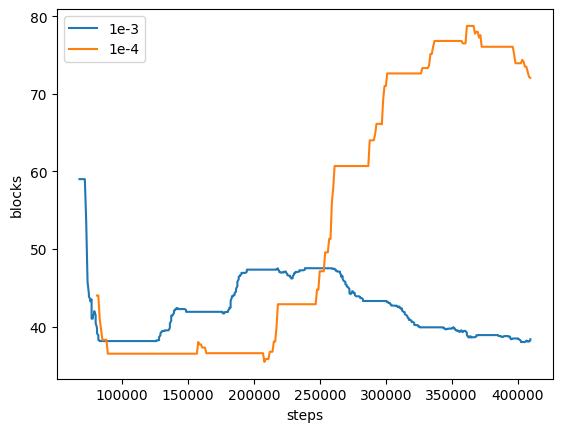

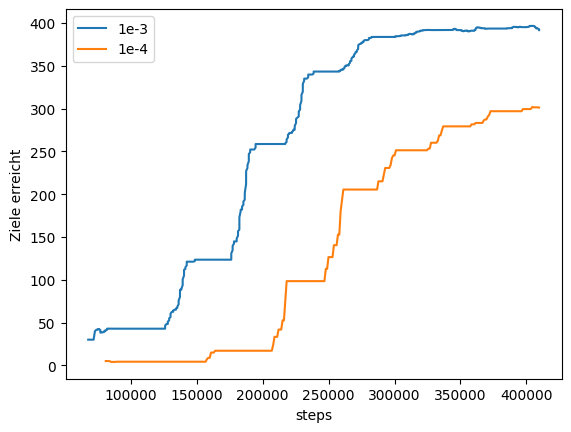

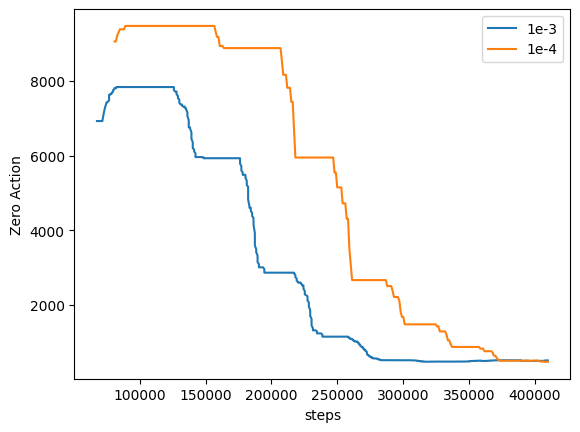

In [12]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_3 = mean(import_data(path, "02_gamma_0_9_", tags))
results_4 = mean(import_data(path, "03_lr_1e-4", tags))
for tag, label in zip(tags, ["reward_mean", "blocks", "Ziele erreicht", "Zero Action"]):
    plot([results_3[tag], results_4[tag]], ["1e-3", "1e-4"], "steps", label)

## Episodenende

C:\Users\Wegma\AppData\Local\Temp\ipykernel_20072\3139792552.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


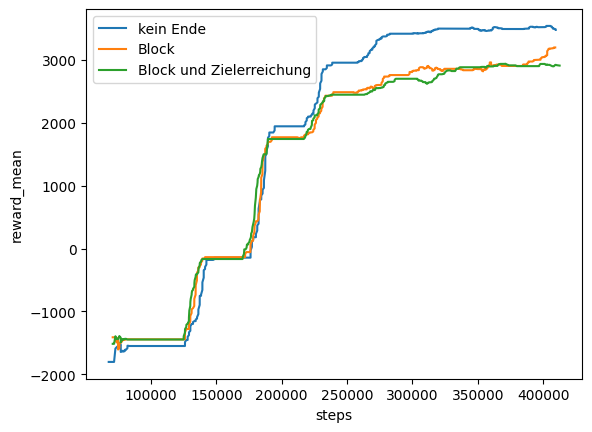

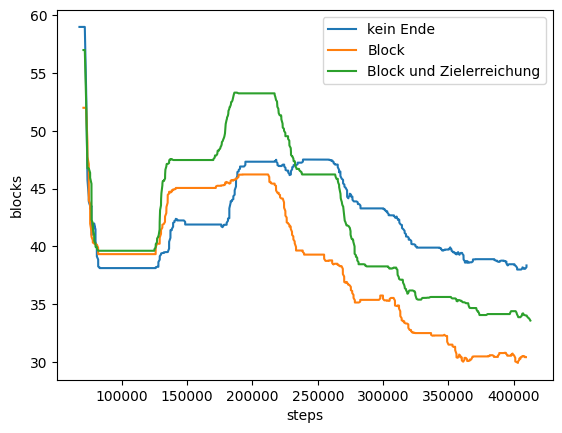

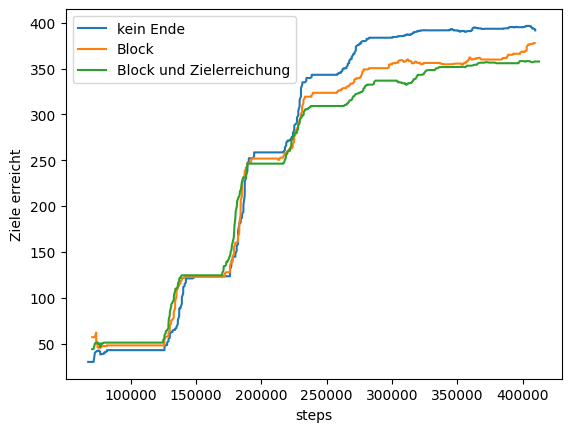

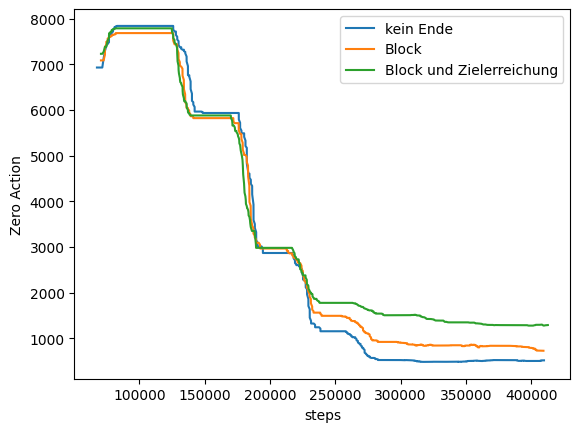

In [13]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_none = mean(import_data(path, "02_gamma_0_9_", tags))
results_block = mean(import_data(path, "04_episode_block", tags))
results_target = mean(import_data(path, "04_episode_target", tags))
for tag, label in zip(tags, ["reward_mean", "blocks", "Ziele erreicht", "Zero Action"]):
    plot([results_none[tag], results_block[tag], results_target[tag]], ["kein Ende", "Block", "Block und Zielerreichung"], "steps", label)

## Rewards

In [ ]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_none = mean(import_data(path, "04_episode_block", tags))
results_dir = mean(import_data(path, "04_rew_dir_-0_1_", tags, exclude=["11-16-50"]))
results_dist = mean(import_data(path, "05_rew_dist_-0_1", tags, exclude = ["01-02-55"]))
results_block = mean(import_data(path, "06_rew_blck_", tags))

In [22]:
results_dist = mean(import_data(path, "05_rew_dist_-0_1", tags, exclude = ["01-02-55"]))

C:\Users\Wegma\AppData\Local\Temp\ipykernel_20072\3139792552.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


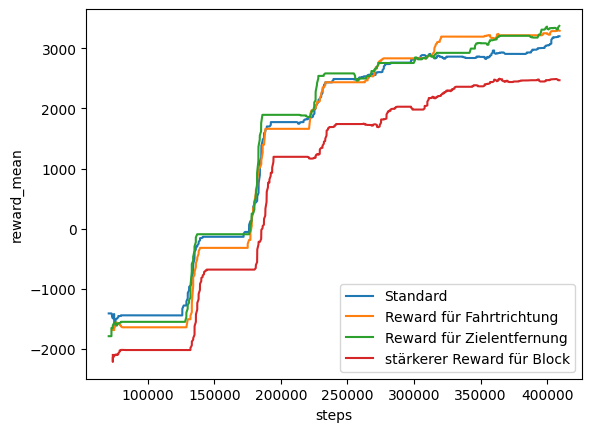

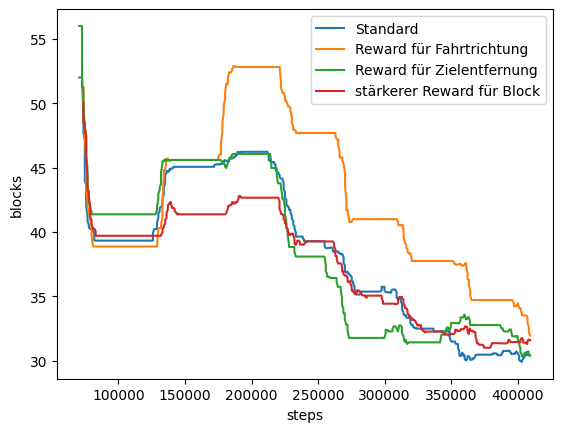

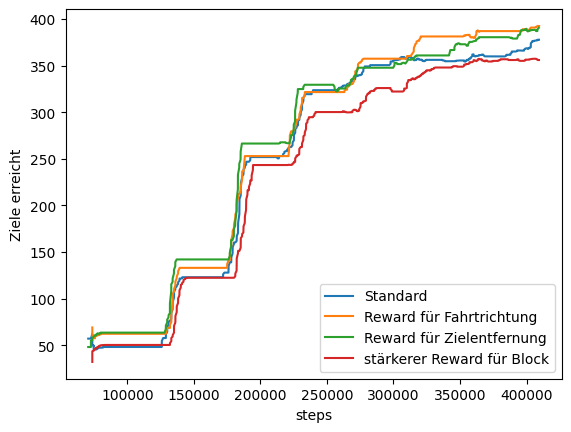

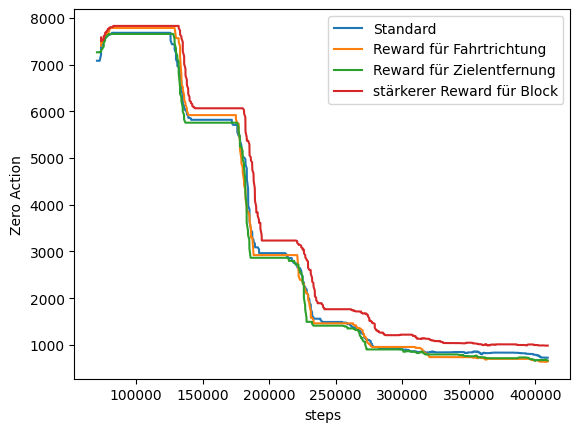

In [24]:
for tag, label in zip(tags, ["reward_mean", "blocks", "Ziele erreicht", "Zero Action"]):
    plot([results_none[tag], results_dir[tag], results_dist[tag], results_block[tag]], ["Standard", "Reward für Fahrtrichtung", "Reward für Zielentfernung", "stärkerer Reward für Block"], "steps", label)

# Dispatching-Experimente in Matrix

In [11]:
path = "../../logs/matrix_dispatching/"

C:\Users\Wegma\AppData\Local\Temp\ipykernel_8068\1254924244.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


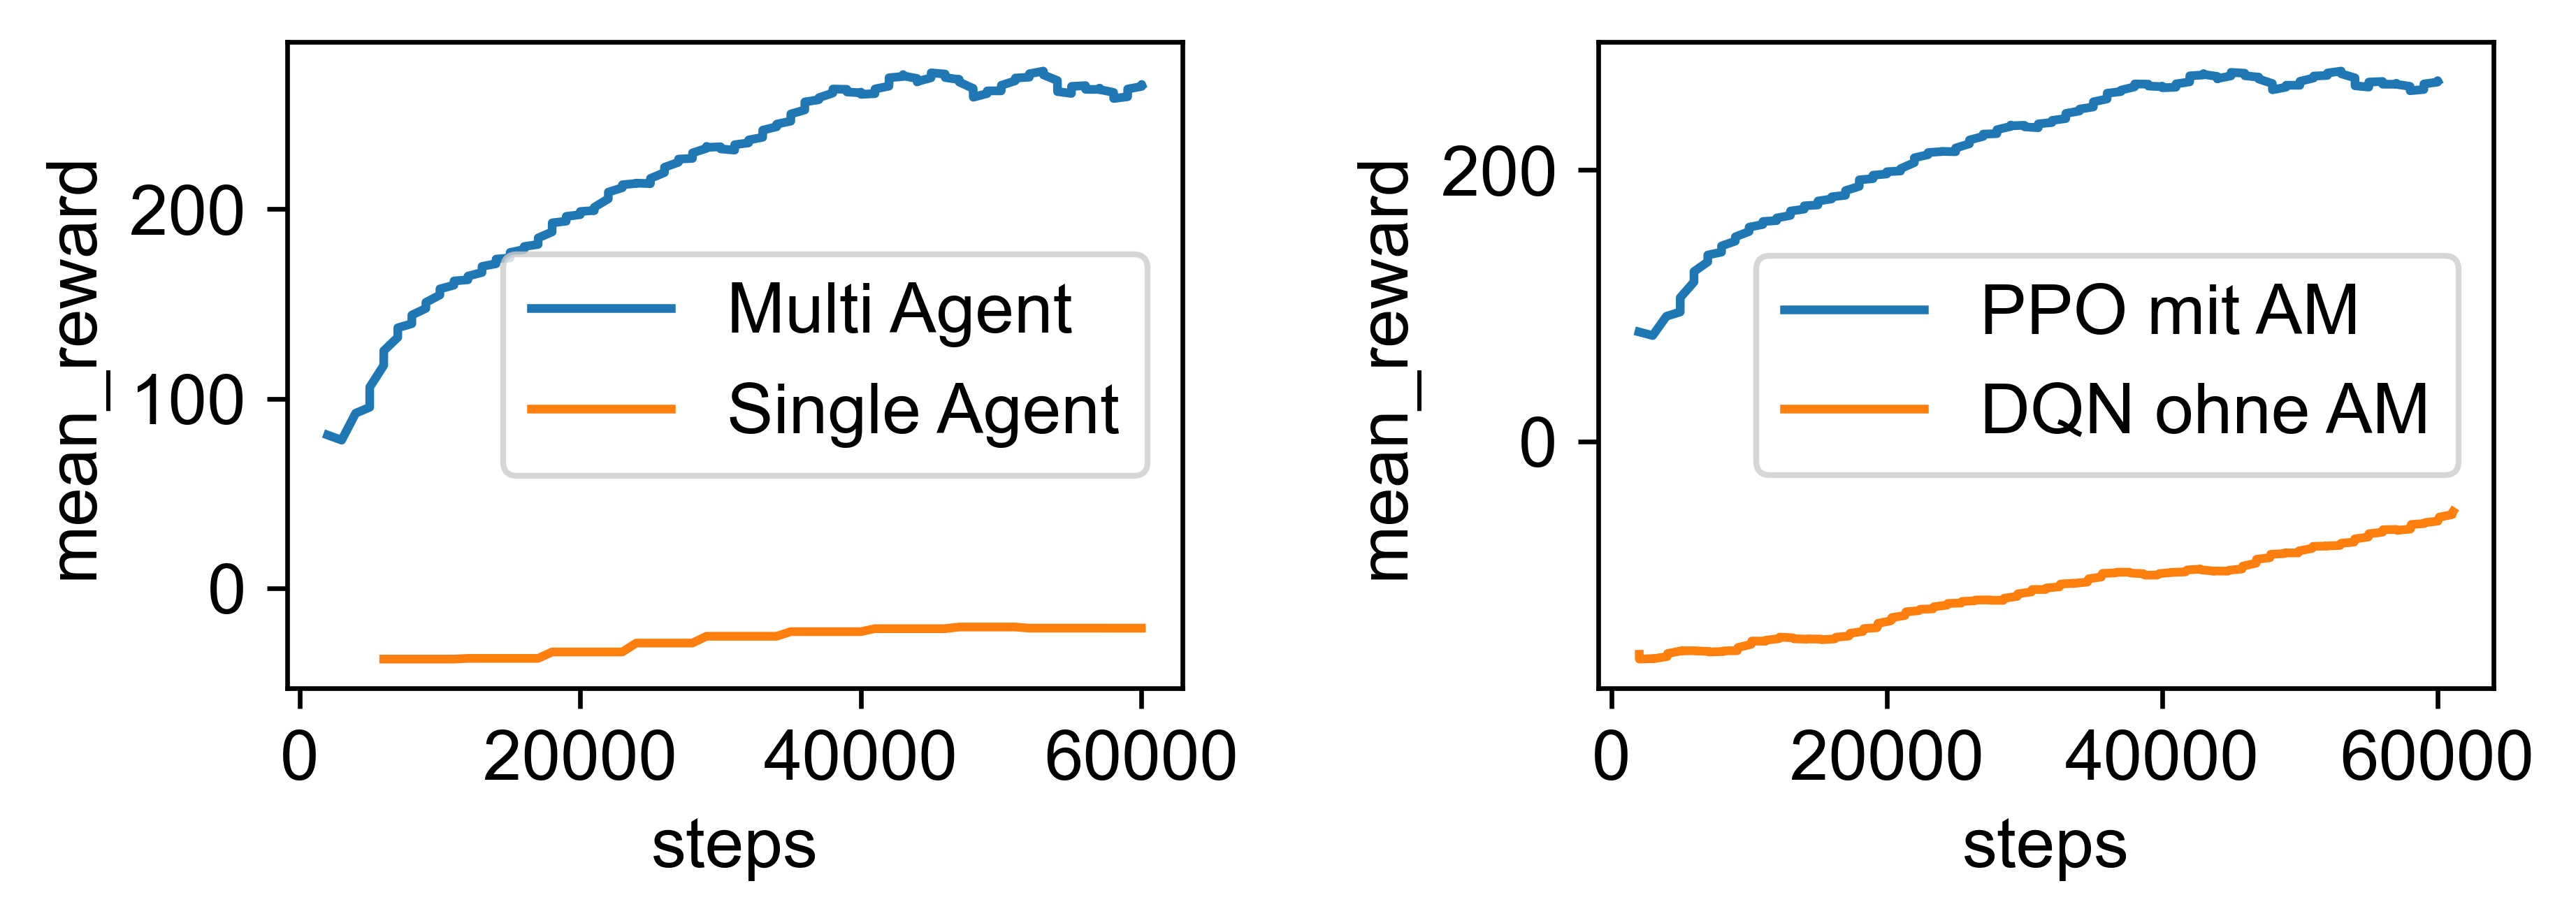

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(16*cm,6*cm), dpi=600)
plot([results_ma, results_sa], ["Multi Agent", "Single Agent"], "steps", "mean_reward", ax=axs[0])
plot([results_ppo, results_dqn], ["PPO mit AM", "DQN ohne AM"], "steps", "mean_reward", ax=axs[1])
plt.tight_layout()
fig.show()
fig.savefig("test2.jpg")

## Multi-Agent vs. Single-Agent

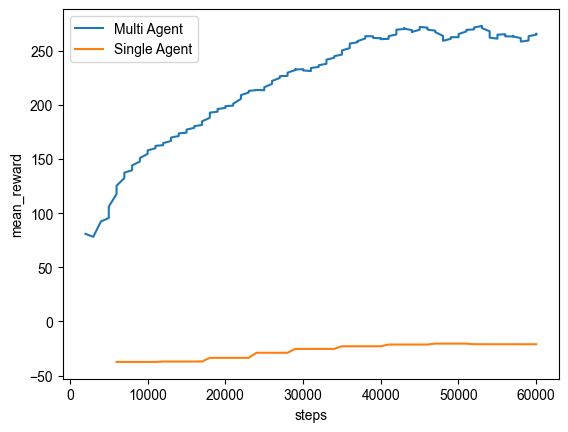

In [19]:
results_ma = mean(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_sa = mean(import_data(path, "01_kozept_sa", 'ray/tune/episode_reward_mean'))
fig1 = plot([results_ma, results_sa], ["Multi Agent", "Single Agent"], "steps", "mean_reward")

## Algorithmus

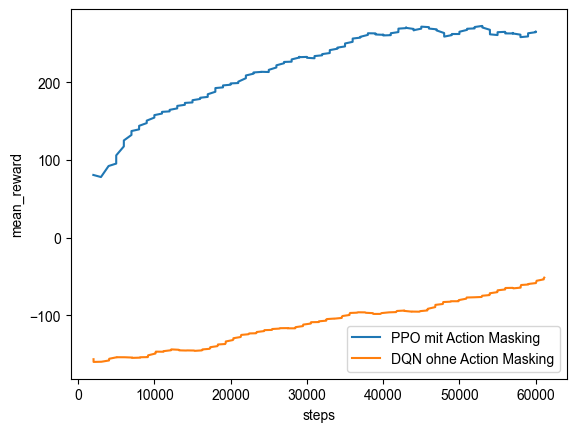

In [41]:
results_ppo = mean(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_dqn = mean(import_data(path, "02_algo_am_dqn", 'ray/tune/episode_reward_mean'))
fig2 = plot([results_ppo, results_dqn], ["PPO mit Action Masking", "DQN ohne Action Masking"], "steps", "mean_reward")

## Model

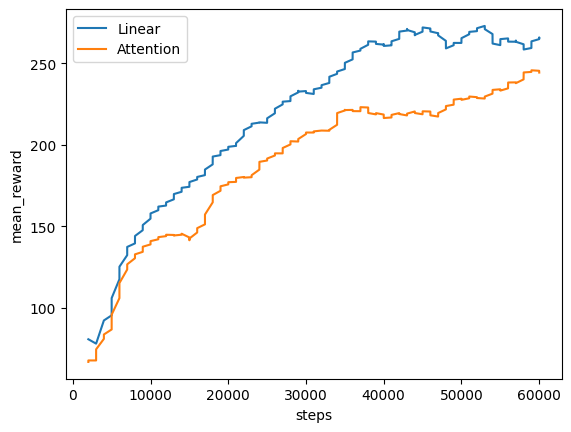

In [60]:
results_lin = mean(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_attn = mean(import_data(path, "03_model_attn", 'ray/tune/episode_reward_mean'))
plot([results_lin, results_attn], ["Linear", "Attention"], "steps", "mean_reward")

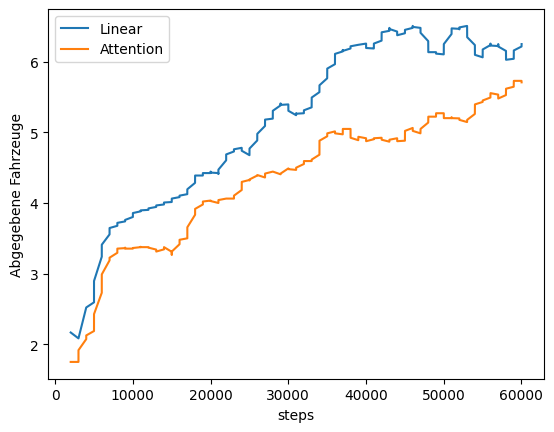

In [59]:
results_lin = mean(import_data(path, "01_kozept_ma", 'ray/tune/custom_metrics/jobDone_mean'))
results_attn = mean(import_data(path, "03_model_attn", 'ray/tune/custom_metrics/jobDone_mean'))
plot([results_lin, results_attn], ["Linear", "Attention"], "steps", "Abgegebene Fahrzeuge")

## Gamma

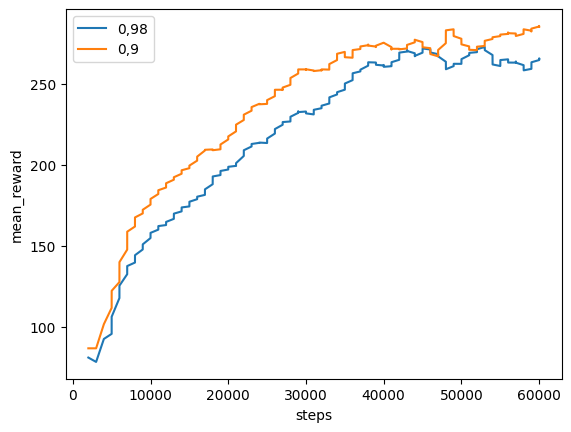

In [61]:
results_98 = mean(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_9 = mean(import_data(path, "04_gamma_0_9", 'ray/tune/episode_reward_mean'))
plot([results_98, results_9], ["0,98", "0,9"], "steps", "mean_reward")

## Learning Rate

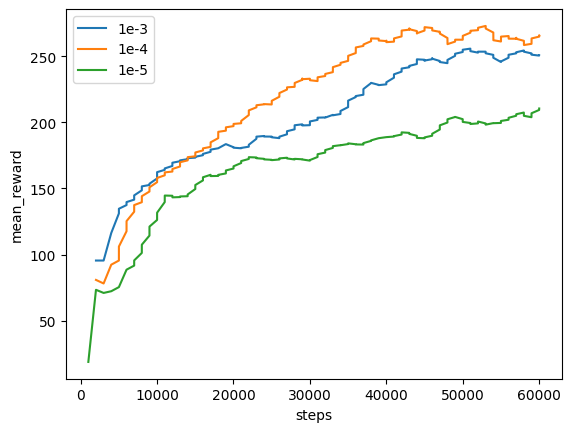

In [62]:
results_3 = mean(import_data(path, "05_lr_e-3", 'ray/tune/episode_reward_mean'))
results_4 = mean(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_5 = mean(import_data(path, "05_lr_e-5", 'ray/tune/episode_reward_mean', exclude=["00-48-23"]))
plot([results_3, results_4, results_5], ["1e-3", "1e-4", "1e-5"], "steps", "mean_reward")